Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# TensorFlow 1.15.2
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1Y2gfhNgbGX7pA0FkA2vbOxdoSmNJVHIK'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1AGW9cRPwBmeJqOo3WXPPcNckrX4jMcIn'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13052
Number of dev sentences:  3263
Number of test sentences:  27625
Number of words in the training dataset:  13860
Number of words in the dev dataset:  6360
Number of words in the test dataset:  21696
Tags in the training dataset: ['I-problem', 'I-treatment', 'B-problem', 'O', 'B-treatment', 'B-test', 'I-test']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['I-problem', 'I-treatment', 'B-problem', 'O', 'B-treatment', 'B-test', 'I-test']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['I-problem', 'I-treatment', 'B-problem', 'O', 'B-treatment', 'B-test', 'I-test']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 10707,She,O
1,Sentence: 10707,had,O
2,Sentence: 10707,normal,O
3,Sentence: 10707,comprehension,O
4,Sentence: 10707,.,O
5,Sentence: 7349,Scott,O
6,Sentence: 7349,Robert,O
7,Sentence: 7349,NP,O
8,Sentence: 7349,80-AUM,O
9,Sentence: 7349,2017-06-29,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Last', 'O'),
 ('menstrual', 'O'),
 ('period', 'O'),
 ('2009-02-21', 'O'),
 ('.', 'O')]

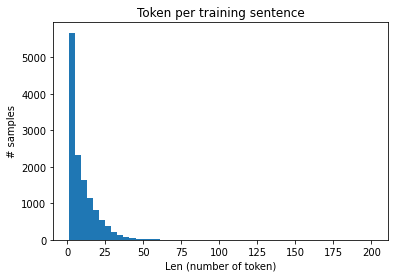

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

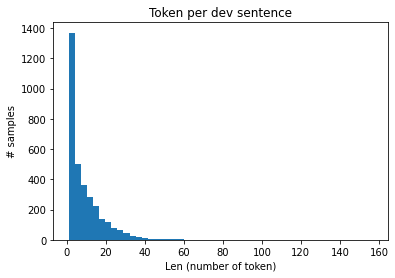

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

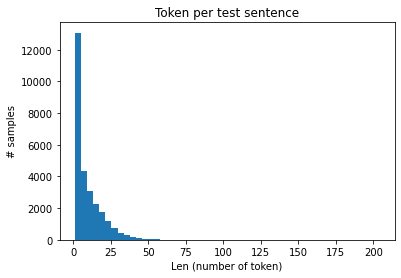

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

5478
endothelialitis
4
B-treatment


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
# X_train, y_train = random_remove_data_points(X_train, y_train, 0.95)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13052
Points in y_train before removal: 13052
Points in X_train before removal: 13052
Points in y_train before removal: 13052


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[4832, 12984]
[3, 3]
[23017, 18574, 22015, 27127, 20996, 2135, 3941, 9890, 4844, 13999, 2908, 1274, 3212, 11436]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[25428, 25738, 13092]
[3, 3, 3]
5478
4
B-problem
methylene
28388
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 1.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 14.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.9 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
     |████████████████████████████████| 596 kB 83.9 MB/s 
     |████████████████████████████████| 6.6 MB 82.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=38e537f292b885137700c07ca8e3a0fa4d4c84c4e44558d5daf60da02c930bb0
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[4832, 12984]
[3, 3]
[23017, 18574, 22015, 27127, 20996, 2135, 3941, 9890, 4844, 13999, 2908, 1274, 3212, 11436]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[25428, 25738, 13092]
[3, 3, 3]
5478
4
B-problem
methylene
28388
7


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [4]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [3]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [' '.join([idx2word[word] for word in sentence]) for sentence in augmented_X_train]
  X_dev_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_dev]
  X_test_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0781595706939697
Training loss per 100 training steps: 0.2552810138884452
Training loss per 100 training steps: 0.1890862781684197
Training loss epoch: 0.18859667692552595
Training accuracy epoch: 0.9424734477124183
Validating model...
Validation Loss: 0.14019957619408766
Validation Accuracy: 0.9583284702769996
Training epoch: 2
Training loss per 100 training steps: 0.038125477731227875
Training loss per 100 training steps: 0.05920941470246209
Training loss per 100 training steps: 0.062007471995511605
Training loss epoch: 0.061573719092206484
Training accuracy epoch: 0.9806219362745098
Validating model...
Validation Loss: 0.1317456836319145
Validation Accuracy: 0.9669117647058824
Training epoch: 3
Training loss per 100 training steps: 0.006866083480417728
Training loss per 100 training steps: 0.022042413325150414
Training loss per 100 training steps: 0.03004852764364054
Training loss epoch: 0.030162356113649758
Training accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12294746641526688
Validation Accuracy: 0.9646584942411924
Validation duration: 3.141701066666667 minutes
F1-score (test): 88.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.89      0.79      0.84      1170
        test       0.91      0.89      0.90      2464
   treatment       0.89      0.87      0.88      1244

   micro avg       0.90      0.86      0.88      4878
   macro avg       0.89      0.85      0.87      4878
weighted avg       0.90      0.86      0.88      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9248090982437134
Training loss per 100 training steps: 0.25388769178402304
Training loss per 100 training steps: 0.1849010479520654
Training loss epoch: 0.18327843387812084
Training accuracy epoch: 0.9430095996732025
Validating model...
Validation Loss: 0.11193133123657283
Validation Accuracy: 0.9659877840024899
Training epoch: 2
Training loss per 100 training steps: 0.08231265842914581
Training loss per 100 training steps: 0.06381825154813209
Training loss per 100 training steps: 0.06492247748702987
Training loss epoch: 0.06484450506932084
Training accuracy epoch: 0.980764910130719
Validating model...
Validation Loss: 0.11756611076713193
Validation Accuracy: 0.9681226657329598
Training epoch: 3
Training loss per 100 training steps: 0.038508739322423935
Training loss per 100 training steps: 0.033493561845383435
Training loss per 100 training steps: 0.034829429119121076
Training loss epoch: 0.03502200203765111
Training accuracy e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11377215241534738
Validation Accuracy: 0.9652054398148148
Validation duration: 3.1276215166666663 minutes
F1-score (test): 88.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.83      0.85      1170
        test       0.92      0.89      0.91      2464
   treatment       0.90      0.89      0.89      1244

   micro avg       0.90      0.88      0.89      4878
   macro avg       0.89      0.87      0.88      4878
weighted avg       0.90      0.88      0.89      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8241209983825684
Training loss per 100 training steps: 0.24916934188787299
Training loss per 100 training steps: 0.189006945294379
Training loss epoch: 0.1879348807475146
Training accuracy epoch: 0.9418555964052288
Validating model...
Validation Loss: 0.11192243305199287
Validation Accuracy: 0.9665810768751945
Training epoch: 2
Training loss per 100 training steps: 0.0331537164747715
Training loss per 100 training steps: 0.06771219465051695
Training loss per 100 training steps: 0.06294406379517446
Training loss epoch: 0.06288454674216279
Training accuracy epoch: 0.9810814950980392
Validating model...
Validation Loss: 0.11617823909310733
Validation Accuracy: 0.9644559212573918
Training epoch: 3
Training loss per 100 training steps: 0.030434560030698776
Training loss per 100 training steps: 0.03007246787189552
Training loss per 100 training steps: 0.033189206580464634
Training loss epoch: 0.03336643342866891
Training accuracy epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12925107824547147
Validation Accuracy: 0.9583086325654924
Validation duration: 3.1156703666666696 minutes
F1-score (test): 86.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.86      0.80      1170
        test       0.89      0.91      0.90      2464
   treatment       0.87      0.85      0.86      1244

   micro avg       0.85      0.88      0.87      4878
   macro avg       0.84      0.87      0.85      4878
weighted avg       0.85      0.88      0.87      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1781368255615234
Training loss per 100 training steps: 0.27315833537590384
Training loss per 100 training steps: 0.20046962443646507
Training loss epoch: 0.19917684988867418
Training accuracy epoch: 0.9392514297385621
Validating model...
Validation Loss: 0.11229375976265646
Validation Accuracy: 0.9647622938064114
Training epoch: 2
Training loss per 100 training steps: 0.05641184002161026
Training loss per 100 training steps: 0.04955612917403036
Training loss per 100 training steps: 0.0599439272955894
Training loss epoch: 0.06030610200204868
Training accuracy epoch: 0.9806168300653594
Validating model...
Validation Loss: 0.1367837778183029
Validation Accuracy: 0.9619952147525677
Training epoch: 3
Training loss per 100 training steps: 0.0098974434658885
Training loss per 100 training steps: 0.03358783543404966
Training loss per 100 training steps: 0.03465201849562686
Training loss epoch: 0.03462823083642505
Training accuracy epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11477671001166864
Validation Accuracy: 0.9637657379177959
Validation duration: 3.1286547666666746 minutes
F1-score (test): 88.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.81      0.84      1170
        test       0.91      0.89      0.90      2464
   treatment       0.91      0.86      0.89      1244

   micro avg       0.90      0.87      0.88      4878
   macro avg       0.89      0.85      0.87      4878
weighted avg       0.90      0.87      0.88      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.269788980484009
Training loss per 100 training steps: 0.2649988017902516
Training loss per 100 training steps: 0.1969844100728112
Training loss epoch: 0.19458322860665767
Training accuracy epoch: 0.940640318627451
Validating model...
Validation Loss: 0.13906756689881578
Validation Accuracy: 0.9607697245564892
Training epoch: 2
Training loss per 100 training steps: 0.04377707093954086
Training loss per 100 training steps: 0.05832735905285445
Training loss per 100 training steps: 0.05936472321424948
Training loss epoch: 0.059843189828326086
Training accuracy epoch: 0.9816125408496731
Validating model...
Validation Loss: 0.12861414974117102
Validation Accuracy: 0.9647428415810768
Training epoch: 3
Training loss per 100 training steps: 0.02916412428021431
Training loss per 100 training steps: 0.03587840686755089
Training loss per 100 training steps: 0.03973085510275739
Training loss epoch: 0.03992787399899909
Training accuracy epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13814806977461558
Validation Accuracy: 0.9620022795280037
Validation duration: 3.132342550000006 minutes
F1-score (test): 87.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.92      0.76      0.83      1170
        test       0.90      0.89      0.90      2464
   treatment       0.88      0.84      0.86      1244

   micro avg       0.90      0.85      0.87      4878
   macro avg       0.90      0.83      0.86      4878
weighted avg       0.90      0.85      0.87      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8198978900909424
Training loss per 100 training steps: 0.2332687338463741
Training loss per 100 training steps: 0.18064933924458512
Training loss epoch: 0.17960453396845683
Training accuracy epoch: 0.9443933823529411
Validating model...
Validation Loss: 0.12151175437896859
Validation Accuracy: 0.9632207049486461
Training epoch: 2
Training loss per 100 training steps: 0.10497169196605682
Training loss per 100 training steps: 0.06335032760340831
Training loss per 100 training steps: 0.0675105614383793
Training loss epoch: 0.067873403324983
Training accuracy epoch: 0.9786815767973855
Validating model...
Validation Loss: 0.12266765715663924
Validation Accuracy: 0.9653750389044506
Training epoch: 3
Training loss per 100 training steps: 0.027580296620726585
Training loss per 100 training steps: 0.038679259875328234
Training loss per 100 training steps: 0.03929883727238546
Training loss epoch: 0.03887695640521854
Training accuracy epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13185242270723124
Validation Accuracy: 0.9573885289634146
Validation duration: 3.1089586000000056 minutes
F1-score (test): 86.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.82      0.81      1170
        test       0.86      0.92      0.89      2464
   treatment       0.88      0.82      0.85      1244

   micro avg       0.85      0.87      0.86      4878
   macro avg       0.85      0.85      0.85      4878
weighted avg       0.85      0.87      0.86      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0379276275634766
Training loss per 100 training steps: 0.2477019771490947
Training loss per 100 training steps: 0.18788854243113332
Training loss epoch: 0.18679873133078218
Training accuracy epoch: 0.9404003267973856
Validating model...
Validation Loss: 0.11464990313877077
Validation Accuracy: 0.965370175848117
Training epoch: 2
Training loss per 100 training steps: 0.1661747843027115
Training loss per 100 training steps: 0.06487190076564946
Training loss per 100 training steps: 0.06571634263912243
Training loss epoch: 0.06520513912626341
Training accuracy epoch: 0.9795496323529411
Validating model...
Validation Loss: 0.12788786865113413
Validation Accuracy: 0.9672084111422347
Training epoch: 3
Training loss per 100 training steps: 0.002742563374340534
Training loss per 100 training steps: 0.02819154455584686
Training loss per 100 training steps: 0.03552218198785512
Training loss epoch: 0.035384836713966056
Training accuracy epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12383100183473693
Validation Accuracy: 0.9616202997967479
Validation duration: 3.1094885666666716 minutes
F1-score (test): 87.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.83      0.82      1170
        test       0.87      0.92      0.90      2464
   treatment       0.88      0.84      0.86      1244

   micro avg       0.86      0.88      0.87      4878
   macro avg       0.86      0.87      0.86      4878
weighted avg       0.86      0.88      0.87      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8816300630569458
Training loss per 100 training steps: 0.2534109447704683
Training loss per 100 training steps: 0.18860512471465923
Training loss epoch: 0.1876998274203609
Training accuracy epoch: 0.9422436683006535
Validating model...
Validation Loss: 0.1154734382551967
Validation Accuracy: 0.9672035480859009
Training epoch: 2
Training loss per 100 training steps: 0.03506205230951309
Training loss per 100 training steps: 0.05792135964286062
Training loss per 100 training steps: 0.06337394839412167
Training loss epoch: 0.06316338168393236
Training accuracy epoch: 0.98046875
Validating model...
Validation Loss: 0.11878642335753231
Validation Accuracy: 0.9668874494242141
Training epoch: 3
Training loss per 100 training steps: 0.020961914211511612
Training loss per 100 training steps: 0.034034662262195405
Training loss per 100 training steps: 0.03651259827140292
Training loss epoch: 0.036369310231998055
Training accuracy epoch: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11112553681057223
Validation Accuracy: 0.9641000804539296
Validation duration: 3.1201107833333177 minutes
F1-score (test): 88.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.84      0.85      1170
        test       0.88      0.93      0.90      2464
   treatment       0.87      0.88      0.88      1244

   micro avg       0.87      0.90      0.88      4878
   macro avg       0.87      0.88      0.88      4878
weighted avg       0.87      0.90      0.88      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0138192176818848
Training loss per 100 training steps: 0.23847434089731168
Training loss per 100 training steps: 0.1881646238665898
Training loss epoch: 0.1864433483923694
Training accuracy epoch: 0.9404769199346406
Validating model...
Validation Loss: 0.12282262287814827
Validation Accuracy: 0.9616937052598817
Training epoch: 2
Training loss per 100 training steps: 0.041795335710048676
Training loss per 100 training steps: 0.05521446973371255
Training loss per 100 training steps: 0.056689582870513275
Training loss epoch: 0.057129870829692876
Training accuracy epoch: 0.9829963235294118
Validating model...
Validation Loss: 0.1386415301182983
Validation Accuracy: 0.9632158418923125
Training epoch: 3
Training loss per 100 training steps: 0.020751971751451492
Training loss per 100 training steps: 0.02797004921214268
Training loss per 100 training steps: 0.028692622067851583
Training loss epoch: 0.028833414655060088
Training accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1286041359611166
Validation Accuracy: 0.9616520579268292
Validation duration: 3.1273641666666965 minutes
F1-score (test): 87.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.89      0.72      0.80      1170
        test       0.91      0.90      0.90      2464
   treatment       0.90      0.85      0.87      1244

   micro avg       0.90      0.84      0.87      4878
   macro avg       0.90      0.82      0.86      4878
weighted avg       0.90      0.84      0.87      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2506027221679688
Training loss per 100 training steps: 0.2616910417518108
Training loss per 100 training steps: 0.1994642653868566
Training loss epoch: 0.198258398685093
Training accuracy epoch: 0.9390880310457517
Validating model...
Validation Loss: 0.1312133394473908
Validation Accuracy: 0.9586348428260192
Training epoch: 2
Training loss per 100 training steps: 0.08393687009811401
Training loss per 100 training steps: 0.07019348769439476
Training loss per 100 training steps: 0.06481260194012256
Training loss epoch: 0.06503797285304423
Training accuracy epoch: 0.9798457924836601
Validating model...
Validation Loss: 0.15571429144919796
Validation Accuracy: 0.9598554699657641
Training epoch: 3
Training loss per 100 training steps: 0.006212370004504919
Training loss per 100 training steps: 0.029795292751070592
Training loss per 100 training steps: 0.03676978620035639
Training loss epoch: 0.0373882545727789
Training accuracy epoch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1285074712337788
Validation Accuracy: 0.9595269097222222
Validation duration: 3.121723633333325 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.90      0.69      0.78      1170
        test       0.89      0.90      0.90      2464
   treatment       0.93      0.81      0.86      1244

   micro avg       0.90      0.83      0.86      4878
   macro avg       0.91      0.80      0.85      4878
weighted avg       0.90      0.83      0.86      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 16315
Points in y_train after augmentation: 16315
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2924094200134277
Training loss per 100 training steps: 0.3138682125136256
Training loss per 100 training steps: 0.2534567310581382
Training loss per 100 training steps: 0.2208836678588806
Training loss per 100 training steps: 0.20094006046411253
Training loss per 100 training steps: 0.1835792119035724
Training loss epoch: 0.18283454001488567
Training accuracy epoch: 0.9432484567901235
Validating model...
Validation Loss: 0.11713603120890684
Validation Accuracy: 0.9632254111321948
Training epoch: 2
Training loss per 100 training steps: 0.0683823749423027
Training loss per 100 training steps: 0.06546523831704042
Training loss per 100 training steps: 0.06097425724552314
Training loss per 100 training steps: 0.06341087416590244
Training loss per 100 training steps: 0.06531076995987431
Training loss per 100 training steps: 0.06715681552159658
Training loss epoch: 0.067418620761315
Training accuracy epoch: 0.9786151960784314
Validatin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11933018616939618
Validation Accuracy: 0.9630513760288066
Validation duration: 2.3693179999999985 minutes
F1-score (test): 87.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.93      0.77      0.84      1170
        test       0.87      0.90      0.88      2464
   treatment       0.92      0.83      0.87      1244

   micro avg       0.89      0.85      0.87      4878
   macro avg       0.91      0.83      0.87      4878
weighted avg       0.90      0.85      0.87      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 16315
Points in y_train after augmentation: 16315
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.115877389907837
Training loss per 100 training steps: 0.31188313087614455
Training loss per 100 training steps: 0.24300933228017976
Training loss per 100 training steps: 0.20995734891687146
Training loss per 100 training steps: 0.18929640238145437
Training loss per 100 training steps: 0.17896008972838864
Training loss epoch: 0.17807915935922852
Training accuracy epoch: 0.9459944625998548
Validating model...
Validation Loss: 0.14364747956221668
Validation Accuracy: 0.9576909392789374
Training epoch: 2
Training loss per 100 training steps: 0.03317492827773094
Training loss per 100 training steps: 0.07939732756401126
Training loss per 100 training steps: 0.0712942771604331
Training loss per 100 training steps: 0.07033360894480133
Training loss per 100 training steps: 0.07097456545570163
Training loss per 100 training steps: 0.06933246808035481
Training loss epoch: 0.06919802347901186
Training accuracy epoch: 0.9762754175744373
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12007111260276428
Validation Accuracy: 0.9640480324074074
Validation duration: 2.379821883333337 minutes
F1-score (test): 87.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.81      0.83      1170
        test       0.89      0.91      0.90      2464
   treatment       0.92      0.84      0.88      1244

   micro avg       0.89      0.87      0.88      4878
   macro avg       0.89      0.85      0.87      4878
weighted avg       0.89      0.87      0.88      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 16315
Points in y_train after augmentation: 16315
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1815690994262695
Training loss per 100 training steps: 0.29469347652969974
Training loss per 100 training steps: 0.23676198766339773
Training loss per 100 training steps: 0.2095627960473596
Training loss per 100 training steps: 0.1915978841121283
Training loss per 100 training steps: 0.17663903971260297
Training loss epoch: 0.1751695019941704
Training accuracy epoch: 0.9456994371822803
Validating model...
Validation Loss: 0.13278593352137535
Validation Accuracy: 0.9613970588235294
Training epoch: 2
Training loss per 100 training steps: 0.04259519651532173
Training loss per 100 training steps: 0.07235129881364358
Training loss per 100 training steps: 0.07032285917397421
Training loss per 100 training steps: 0.06225040361309962
Training loss per 100 training steps: 0.06369374401721072
Training loss per 100 training steps: 0.06492611618820363
Training loss epoch: 0.06499875381534152
Training accuracy epoch: 0.9802582607116921
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13470082015986987
Validation Accuracy: 0.9581163194444444
Validation duration: 2.374123350000006 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.87      0.83      1170
        test       0.87      0.90      0.88      2464
   treatment       0.84      0.86      0.85      1244

   micro avg       0.84      0.88      0.86      4878
   macro avg       0.84      0.88      0.86      4878
weighted avg       0.84      0.88      0.86      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 16315
Points in y_train after augmentation: 16315
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8894838094711304
Training loss per 100 training steps: 0.30473930539913696
Training loss per 100 training steps: 0.24123965480842105
Training loss per 100 training steps: 0.21411779704209777
Training loss per 100 training steps: 0.1945798544868121
Training loss per 100 training steps: 0.1806733614956577
Training loss epoch: 0.18015257015860842
Training accuracy epoch: 0.9431758351488744
Validating model...
Validation Loss: 0.13796930967410112
Validation Accuracy: 0.9546370967741936
Training epoch: 2
Training loss per 100 training steps: 0.020217837765812874
Training loss per 100 training steps: 0.05558556904278622
Training loss per 100 training steps: 0.06931064137609777
Training loss per 100 training steps: 0.07175811092783867
Training loss per 100 training steps: 0.07340664700244988
Training loss per 100 training steps: 0.0722637438352876
Training loss epoch: 0.07278665207490763
Training accuracy epoch: 0.9764705882352941
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13963224142315556
Validation Accuracy: 0.9556568287037037
Validation duration: 2.3498492000000017 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.86      0.80      1170
        test       0.91      0.87      0.89      2464
   treatment       0.82      0.89      0.86      1244

   micro avg       0.84      0.87      0.86      4878
   macro avg       0.83      0.87      0.85      4878
weighted avg       0.85      0.87      0.86      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 16315
Points in y_train after augmentation: 16315
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5657355785369873
Training loss per 100 training steps: 0.2731055679297683
Training loss per 100 training steps: 0.22766586175809303
Training loss per 100 training steps: 0.19752370424110727
Training loss per 100 training steps: 0.18273527272268572
Training loss per 100 training steps: 0.16812056667002256
Training loss epoch: 0.16682366359723258
Training accuracy epoch: 0.9471200980392157
Validating model...
Validation Loss: 0.12828715598694615
Validation Accuracy: 0.9595390575585073
Training epoch: 2
Training loss per 100 training steps: 0.09058472514152527
Training loss per 100 training steps: 0.06231675077561695
Training loss per 100 training steps: 0.06618480149318293
Training loss per 100 training steps: 0.06650624114422876
Training loss per 100 training steps: 0.06950184126893184
Training loss per 100 training steps: 0.07119443199035903
Training loss epoch: 0.07075844031493819
Training accuracy epoch: 0.9781749273783588
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12641110941465875
Validation Accuracy: 0.9595992476851852
Validation duration: 2.446351250000013 minutes
F1-score (test): 86.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.79      0.83      1170
        test       0.89      0.89      0.89      2464
   treatment       0.85      0.86      0.85      1244

   micro avg       0.87      0.86      0.86      4878
   macro avg       0.87      0.84      0.86      4878
weighted avg       0.87      0.86      0.86      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 16315
Points in y_train after augmentation: 16315
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3875792026519775
Training loss per 100 training steps: 0.3236506820130761
Training loss per 100 training steps: 0.24731881598436936
Training loss per 100 training steps: 0.21167166316201075
Training loss per 100 training steps: 0.18947034835248738
Training loss per 100 training steps: 0.1745326833041039
Training loss epoch: 0.1730798760191629
Training accuracy epoch: 0.9461896332607117
Validating model...
Validation Loss: 0.13041659862296107
Validation Accuracy: 0.9601616856419988
Training epoch: 2
Training loss per 100 training steps: 0.3031088411808014
Training loss per 100 training steps: 0.05330545620849854
Training loss per 100 training steps: 0.06185506384608924
Training loss per 100 training steps: 0.06127488682397712
Training loss per 100 training steps: 0.06356799379316277
Training loss per 100 training steps: 0.06453930006962931
Training loss epoch: 0.0647846226343045
Training accuracy epoch: 0.9797680646332607
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14461137312173378
Validation Accuracy: 0.9543346514917695
Validation duration: 2.4284966666666454 minutes
F1-score (test): 85.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.82      0.80      1170
        test       0.82      0.93      0.87      2464
   treatment       0.85      0.88      0.87      1244

   micro avg       0.82      0.89      0.85      4878
   macro avg       0.82      0.88      0.85      4878
weighted avg       0.82      0.89      0.85      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 16315
Points in y_train after augmentation: 16315
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9739079475402832
Training loss per 100 training steps: 0.30049212310131235
Training loss per 100 training steps: 0.23580283845835065
Training loss per 100 training steps: 0.20491078476177102
Training loss per 100 training steps: 0.18863095127817178
Training loss per 100 training steps: 0.17823282703329732
Training loss epoch: 0.17802011154537253
Training accuracy epoch: 0.9449028685548294
Validating model...
Validation Loss: 0.13547183163281457
Validation Accuracy: 0.9586397058823529
Training epoch: 2
Training loss per 100 training steps: 0.020523319020867348
Training loss per 100 training steps: 0.06385420789909872
Training loss per 100 training steps: 0.06627059987438055
Training loss per 100 training steps: 0.0682697510257815
Training loss per 100 training steps: 0.06662206314568016
Training loss per 100 training steps: 0.0660154496186214
Training loss epoch: 0.06615336388920197
Training accuracy epoch: 0.9787990196078431
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1381906340625897
Validation Accuracy: 0.9594184027777778
Validation duration: 2.381036083333311 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 86.5%
              precision    recall  f1-score   support

     problem       0.85      0.78      0.81      1170
        test       0.90      0.88      0.89      2464
   treatment       0.87      0.86      0.86      1244

   micro avg       0.88      0.85      0.86      4878
   macro avg       0.87      0.84      0.86      4878
weighted avg       0.88      0.85      0.86      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 16315
Points in y_train after augmentation: 16315
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1446170806884766
Training loss per 100 training steps: 0.3009696126094844
Training loss per 100 training steps: 0.23325511654236572
Training loss per 100 training steps: 0.2095942688406603
Training loss per 100 training steps: 0.1885080834655579
Training loss per 100 training steps: 0.1791296112620664
Training loss epoch: 0.17701430409124083
Training accuracy epoch: 0.9434935548293392
Validating model...
Validation Loss: 0.1346442141825808
Validation Accuracy: 0.9583234503478811
Training epoch: 2
Training loss per 100 training steps: 0.1066461130976677
Training loss per 100 training steps: 0.07280944594836766
Training loss per 100 training steps: 0.06859273636894328
Training loss per 100 training steps: 0.06647503108638601
Training loss per 100 training steps: 0.06593530207606464
Training loss per 100 training steps: 0.06488459807645879
Training loss epoch: 0.06473972740007893
Training accuracy epoch: 0.9797067901234568
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12988218164065513
Validation Accuracy: 0.9622034143518519
Validation duration: 2.3882093500000035 minutes
F1-score (test): 87.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.79      0.83      1170
        test       0.91      0.88      0.89      2464
   treatment       0.93      0.81      0.87      1244

   micro avg       0.91      0.84      0.87      4878
   macro avg       0.91      0.83      0.86      4878
weighted avg       0.91      0.84      0.87      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 16315
Points in y_train after augmentation: 16315
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9652644395828247
Training loss per 100 training steps: 0.3102308059535404
Training loss per 100 training steps: 0.23425531248325732
Training loss per 100 training steps: 0.20288934367879036
Training loss per 100 training steps: 0.18921018064955708
Training loss per 100 training steps: 0.18049763362137172
Training loss epoch: 0.1799237438304094
Training accuracy epoch: 0.9425744371822804
Validating model...
Validation Loss: 0.1736996497310625
Validation Accuracy: 0.9491223908918406
Training epoch: 2
Training loss per 100 training steps: 0.025148622691631317
Training loss per 100 training steps: 0.06843284904809281
Training loss per 100 training steps: 0.06557060188708817
Training loss per 100 training steps: 0.06391325146323411
Training loss per 100 training steps: 0.06770522407275809
Training loss per 100 training steps: 0.06654137560606055
Training loss epoch: 0.06698767098109694
Training accuracy epoch: 0.9777460058097314
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13432674703660638
Validation Accuracy: 0.9604311342592593
Validation duration: 2.3864261166666743 minutes
F1-score (test): 87.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.88      0.83      1170
        test       0.86      0.93      0.89      2464
   treatment       0.88      0.86      0.87      1244

   micro avg       0.85      0.90      0.87      4878
   macro avg       0.84      0.89      0.86      4878
weighted avg       0.85      0.90      0.87      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 16315
Points in y_train after augmentation: 16315
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8893333673477173
Training loss per 100 training steps: 0.31272578954991725
Training loss per 100 training steps: 0.22967390122068165
Training loss per 100 training steps: 0.20184311670161462
Training loss per 100 training steps: 0.18475336592616584
Training loss per 100 training steps: 0.17431096527948528
Training loss epoch: 0.17286744296879453
Training accuracy epoch: 0.9457607116920843
Validating model...
Validation Loss: 0.118102089049952
Validation Accuracy: 0.9632155281467426
Training epoch: 2
Training loss per 100 training steps: 0.20499765872955322
Training loss per 100 training steps: 0.06896702144848238
Training loss per 100 training steps: 0.06673147437215982
Training loss per 100 training steps: 0.0695688184431949
Training loss per 100 training steps: 0.06721830906513661
Training loss per 100 training steps: 0.06825916114669413
Training loss epoch: 0.06819154717571413
Training accuracy epoch: 0.9790441176470588
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13417415029026517
Validation Accuracy: 0.9565771283436214
Validation duration: 2.3807950333333188 minutes
F1-score (test): 85.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.73      0.88      0.80      1170
        test       0.86      0.92      0.89      2464
   treatment       0.92      0.79      0.85      1244

   micro avg       0.83      0.88      0.86      4878
   macro avg       0.83      0.87      0.85      4878
weighted avg       0.84      0.88      0.86      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.215693235397339
Training loss per 100 training steps: 0.33854773668295673
Training loss per 100 training steps: 0.2578450901924971
Training loss per 100 training steps: 0.22356894816522582
Training loss per 100 training steps: 0.19951856219583652
Training loss per 100 training steps: 0.18602415255202118
Training loss per 100 training steps: 0.17435905911236035
Training loss epoch: 0.17280895941741642
Training accuracy epoch: 0.9468954248366013
Validating model...
Validation Loss: 0.12406462126904551
Validation Accuracy: 0.9641247628083491
Training epoch: 2
Training loss per 100 training steps: 0.11528557538986206
Training loss per 100 training steps: 0.06030313705214032
Training loss per 100 training steps: 0.057082550907716044
Training loss per 100 training steps: 0.059304212810598514
Training loss per 100 training steps: 0.06101039660882038
Training loss per 100 training steps: 0.06495579291542178
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1363584208221356
Validation Accuracy: 0.9585503472222222
Validation duration: 2.302219516666666 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.78      0.82      1170
        test       0.83      0.94      0.88      2464
   treatment       0.86      0.88      0.87      1244

   micro avg       0.84      0.88      0.86      4878
   macro avg       0.85      0.86      0.86      4878
weighted avg       0.85      0.88      0.86      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1021580696105957
Training loss per 100 training steps: 0.31424090085495815
Training loss per 100 training steps: 0.24158938893056775
Training loss per 100 training steps: 0.21400906517173462
Training loss per 100 training steps: 0.19346850622965586
Training loss per 100 training steps: 0.18036608955081174
Training loss per 100 training steps: 0.17119626495088397
Training loss epoch: 0.17039687653053917
Training accuracy epoch: 0.9472017973856209
Validating model...
Validation Loss: 0.13151117954768388
Validation Accuracy: 0.9586100569259962
Training epoch: 2
Training loss per 100 training steps: 0.0953969731926918
Training loss per 100 training steps: 0.06547182546651895
Training loss per 100 training steps: 0.06636990976765456
Training loss per 100 training steps: 0.0681034375354957
Training loss per 100 training steps: 0.07068378194130753
Training loss per 100 training steps: 0.06945287797784994
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1370229489451352
Validation Accuracy: 0.9549334490740741
Validation duration: 2.3665780499999984 minutes
F1-score (test): 85.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.83      0.81      1170
        test       0.87      0.89      0.88      2464
   treatment       0.79      0.91      0.85      1244

   micro avg       0.83      0.88      0.86      4878
   macro avg       0.82      0.88      0.85      4878
weighted avg       0.83      0.88      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.138986825942993
Training loss per 100 training steps: 0.31600445774522157
Training loss per 100 training steps: 0.2499908751330862
Training loss per 100 training steps: 0.21980982249683123
Training loss per 100 training steps: 0.1982617317954371
Training loss per 100 training steps: 0.1855288374752639
Training loss per 100 training steps: 0.17715460684819895
Training loss epoch: 0.17588157608368574
Training accuracy epoch: 0.9453125
Validating model...
Validation Loss: 0.13552949189747154
Validation Accuracy: 0.9613970588235294
Training epoch: 2
Training loss per 100 training steps: 0.01155929546803236
Training loss per 100 training steps: 0.07415569768780565
Training loss per 100 training steps: 0.06450449143430978
Training loss per 100 training steps: 0.06354209327040723
Training loss per 100 training steps: 0.06535922218752245
Training loss per 100 training steps: 0.0672879690450092
Training loss per 100 training steps: 0.066

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13137523281060298
Validation Accuracy: 0.9606119791666666
Validation duration: 2.4129356499999934 minutes
F1-score (test): 87.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.85      0.83      1170
        test       0.89      0.90      0.90      2464
   treatment       0.88      0.85      0.86      1244

   micro avg       0.86      0.88      0.87      4878
   macro avg       0.86      0.87      0.86      4878
weighted avg       0.86      0.88      0.87      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.714329719543457
Training loss per 100 training steps: 0.32860280479313714
Training loss per 100 training steps: 0.26148133809256613
Training loss per 100 training steps: 0.2220541653888566
Training loss per 100 training steps: 0.2084464742418871
Training loss per 100 training steps: 0.19401804714495252
Training loss per 100 training steps: 0.182681573822958
Training loss epoch: 0.1801344507192779
Training accuracy epoch: 0.9442912581699346
Validating model...
Validation Loss: 0.13573999776660153
Validation Accuracy: 0.9589460784313726
Training epoch: 2
Training loss per 100 training steps: 0.0034535396844148636
Training loss per 100 training steps: 0.055933376423793264
Training loss per 100 training steps: 0.05876594845701324
Training loss per 100 training steps: 0.05851148433659993
Training loss per 100 training steps: 0.06217544058023109
Training loss per 100 training steps: 0.06505745135878813
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13196563194260644
Validation Accuracy: 0.9597800925925926
Validation duration: 2.361848216666658 minutes
F1-score (test): 86.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.81      0.83      1170
        test       0.93      0.85      0.89      2464
   treatment       0.85      0.89      0.87      1244

   micro avg       0.89      0.85      0.87      4878
   macro avg       0.87      0.85      0.86      4878
weighted avg       0.89      0.85      0.87      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.766218662261963
Training loss per 100 training steps: 0.3692619699320876
Training loss per 100 training steps: 0.2783614891808276
Training loss per 100 training steps: 0.23995621304996187
Training loss per 100 training steps: 0.21143058920046895
Training loss per 100 training steps: 0.1920653424214594
Training loss per 100 training steps: 0.18047685427172808
Training loss epoch: 0.17864956643456728
Training accuracy epoch: 0.9434232026143791
Validating model...
Validation Loss: 0.12979672274406195
Validation Accuracy: 0.9601616856419988
Training epoch: 2
Training loss per 100 training steps: 0.06047741323709488
Training loss per 100 training steps: 0.06242850962058079
Training loss per 100 training steps: 0.061215589116026294
Training loss per 100 training steps: 0.06278943184893145
Training loss per 100 training steps: 0.060587005907474574
Training loss per 100 training steps: 0.06283004416286213
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13302521578966495
Validation Accuracy: 0.9585463284465021
Validation duration: 2.2947045166666613 minutes
F1-score (test): 86.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.83      0.81      1170
        test       0.88      0.90      0.89      2464
   treatment       0.85      0.89      0.86      1244

   micro avg       0.85      0.88      0.86      4878
   macro avg       0.84      0.87      0.85      4878
weighted avg       0.85      0.88      0.86      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7848294973373413
Training loss per 100 training steps: 0.3251564999175544
Training loss per 100 training steps: 0.2420284821100496
Training loss per 100 training steps: 0.2203468538053408
Training loss per 100 training steps: 0.20089445794767646
Training loss per 100 training steps: 0.18366594315913623
Training loss per 100 training steps: 0.17431293638460277
Training loss epoch: 0.17335563805791263
Training accuracy epoch: 0.944420877325289
Validating model...
Validation Loss: 0.13063662745487675
Validation Accuracy: 0.9619999209361164
Training epoch: 2
Training loss per 100 training steps: 0.032038211822509766
Training loss per 100 training steps: 0.05505060264840722
Training loss per 100 training steps: 0.06027059188397573
Training loss per 100 training steps: 0.06247927246041336
Training loss per 100 training steps: 0.06258197772540756
Training loss per 100 training steps: 0.06092392572642354
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13017405768348705
Validation Accuracy: 0.9602141203703703
Validation duration: 2.333089933333334 minutes
F1-score (test): 86.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.77      0.82      1170
        test       0.90      0.88      0.89      2464
   treatment       0.88      0.84      0.86      1244

   micro avg       0.89      0.84      0.86      4878
   macro avg       0.88      0.83      0.85      4878
weighted avg       0.89      0.84      0.86      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9771021604537964
Training loss per 100 training steps: 0.339236267611827
Training loss per 100 training steps: 0.25510324884335794
Training loss per 100 training steps: 0.2154160585390571
Training loss per 100 training steps: 0.20304695606937728
Training loss per 100 training steps: 0.19252742166926493
Training loss per 100 training steps: 0.1786672171288962
Training loss epoch: 0.17826600419509597
Training accuracy epoch: 0.9442284125188537
Validating model...
Validation Loss: 0.1304368625815008
Validation Accuracy: 0.9583333333333334
Training epoch: 2
Training loss per 100 training steps: 0.07515816390514374
Training loss per 100 training steps: 0.06927498080998216
Training loss per 100 training steps: 0.06625723950124685
Training loss per 100 training steps: 0.06428429612153491
Training loss per 100 training steps: 0.061662190294176564
Training loss per 100 training steps: 0.06386375482363288
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13988507199812578
Validation Accuracy: 0.9545717592592593
Validation duration: 2.3260820333333263 minutes
F1-score (test): 85.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.69      0.89      0.78      1170
        test       0.87      0.92      0.90      2464
   treatment       0.84      0.89      0.87      1244

   micro avg       0.81      0.91      0.86      4878
   macro avg       0.80      0.90      0.85      4878
weighted avg       0.82      0.91      0.86      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2110466957092285
Training loss per 100 training steps: 0.336679190065306
Training loss per 100 training steps: 0.25706832380548345
Training loss per 100 training steps: 0.22275217034640502
Training loss per 100 training steps: 0.20442892502566004
Training loss per 100 training steps: 0.18792261552816616
Training loss per 100 training steps: 0.17607351795564127
Training loss epoch: 0.1764015889760058
Training accuracy epoch: 0.9433210784313726
Validating model...
Validation Loss: 0.12707375352928305
Validation Accuracy: 0.9613871758380772
Training epoch: 2
Training loss per 100 training steps: 0.008650621399283409
Training loss per 100 training steps: 0.05609989594748834
Training loss per 100 training steps: 0.058595754810555636
Training loss per 100 training steps: 0.05677800112155628
Training loss per 100 training steps: 0.059858101253900585
Training loss per 100 training steps: 0.061167132752941
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11887754522875318
Validation Accuracy: 0.9656394675925926
Validation duration: 2.3331774999999957 minutes
F1-score (test): 88.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.86      0.84      1170
        test       0.91      0.91      0.91      2464
   treatment       0.86      0.91      0.89      1244

   micro avg       0.87      0.90      0.89      4878
   macro avg       0.86      0.89      0.88      4878
weighted avg       0.88      0.90      0.89      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2786970138549805
Training loss per 100 training steps: 0.33782750633683534
Training loss per 100 training steps: 0.2563454323860617
Training loss per 100 training steps: 0.21672894085673894
Training loss per 100 training steps: 0.19494556214665051
Training loss per 100 training steps: 0.18089539896391943
Training loss per 100 training steps: 0.17129917200437797
Training loss epoch: 0.17070648551072462
Training accuracy epoch: 0.9459252450980392
Validating model...
Validation Loss: 0.12616661375425026
Validation Accuracy: 0.960774430740038
Training epoch: 2
Training loss per 100 training steps: 0.05266966298222542
Training loss per 100 training steps: 0.05530639399836614
Training loss per 100 training steps: 0.05555415708387493
Training loss per 100 training steps: 0.05933592239102005
Training loss per 100 training steps: 0.0600116776898033
Training loss per 100 training steps: 0.06356012568400825
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1374033397776118
Validation Accuracy: 0.9569589120370371
Validation duration: 2.3353436999999757 minutes
F1-score (test): 86.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.88      0.79      1170
        test       0.90      0.89      0.89      2464
   treatment       0.87      0.86      0.86      1244

   micro avg       0.84      0.88      0.86      4878
   macro avg       0.83      0.88      0.85      4878
weighted avg       0.85      0.88      0.86      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.061351776123047
Training loss per 100 training steps: 0.34375979603812246
Training loss per 100 training steps: 0.26189787511653567
Training loss per 100 training steps: 0.22607085178683564
Training loss per 100 training steps: 0.2054092588061072
Training loss per 100 training steps: 0.19081618990228622
Training loss per 100 training steps: 0.17989157895346833
Training loss epoch: 0.17886114825633068
Training accuracy epoch: 0.9435253267973857
Validating model...
Validation Loss: 0.1336696700389296
Validation Accuracy: 0.960171568627451
Training epoch: 2
Training loss per 100 training steps: 0.09964501857757568
Training loss per 100 training steps: 0.06609237486367474
Training loss per 100 training steps: 0.059380450581932503
Training loss per 100 training steps: 0.06359277434834276
Training loss per 100 training steps: 0.06629844948427607
Training loss per 100 training steps: 0.06544575320501922
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13596522129052943
Validation Accuracy: 0.9612268518518519
Validation duration: 2.3159771833333553 minutes
F1-score (test): 86.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.91      0.77      0.84      1170
        test       0.87      0.92      0.90      2464
   treatment       0.90      0.79      0.84      1244

   micro avg       0.89      0.85      0.87      4878
   macro avg       0.89      0.83      0.86      4878
weighted avg       0.89      0.85      0.87      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 22841
Points in y_train after augmentation: 22841
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8548579216003418
Training loss per 100 training steps: 0.30175390238366506
Training loss per 100 training steps: 0.24581879491347874
Training loss per 100 training steps: 0.22282888415730573
Training loss per 100 training steps: 0.19865630129282538
Training loss per 100 training steps: 0.18948991535911838
Training loss per 100 training steps: 0.17601398439859403
Training loss per 100 training steps: 0.16775765923448385
Training loss epoch: 0.16675329995758997
Training accuracy epoch: 0.9473354341736695
Validating model...
Validation Loss: 0.1409384084765014
Validation Accuracy: 0.9555660974067046
Training epoch: 2
Training loss per 100 training steps: 0.010771045461297035
Training loss per 100 training steps: 0.04964567152183909
Training loss per 100 training steps: 0.0614307002970643
Training loss per 100 training steps: 0.05962338825290175
Training loss per 100 training steps: 0.058322162846709484
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15147371575181345
Validation Accuracy: 0.9524337705761318
Validation duration: 2.334039999999974 minutes
F1-score (test): 83.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.77      0.79      1170
        test       0.78      0.94      0.85      2464
   treatment       0.93      0.73      0.81      1244

   micro avg       0.81      0.85      0.83      4878
   macro avg       0.84      0.81      0.82      4878
weighted avg       0.83      0.85      0.83      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 22841
Points in y_train after augmentation: 22841
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7219456434249878
Training loss per 100 training steps: 0.29604064186315726
Training loss per 100 training steps: 0.2364483243178817
Training loss per 100 training steps: 0.20948692676193542
Training loss per 100 training steps: 0.1929618220653227
Training loss per 100 training steps: 0.18264453644267545
Training loss per 100 training steps: 0.17414457498260846
Training loss per 100 training steps: 0.16778565309051632
Training loss epoch: 0.1668791053627542
Training accuracy epoch: 0.9477608543417366
Validating model...
Validation Loss: 0.13595132705956406
Validation Accuracy: 0.9577205882352942
Training epoch: 2
Training loss per 100 training steps: 0.17267946898937225
Training loss per 100 training steps: 0.05460841726917442
Training loss per 100 training steps: 0.0612688239980072
Training loss per 100 training steps: 0.06178355028878347
Training loss per 100 training steps: 0.05993360131145792
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13885638842556444
Validation Accuracy: 0.955833654835391
Validation duration: 2.391054500000003 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.77      0.81      1170
        test       0.88      0.87      0.88      2464
   treatment       0.89      0.81      0.85      1244

   micro avg       0.88      0.83      0.86      4878
   macro avg       0.88      0.82      0.85      4878
weighted avg       0.88      0.83      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 22841
Points in y_train after augmentation: 22841
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1000144481658936
Training loss per 100 training steps: 0.3512491757179251
Training loss per 100 training steps: 0.2564692381695284
Training loss per 100 training steps: 0.22436479210816448
Training loss per 100 training steps: 0.2056590696852515
Training loss per 100 training steps: 0.1898274070168743
Training loss per 100 training steps: 0.17641538112736563
Training loss per 100 training steps: 0.16912830367198775
Training loss epoch: 0.1677805458427686
Training accuracy epoch: 0.9469852941176471
Validating model...
Validation Loss: 0.1145134240653658
Validation Accuracy: 0.9647572738772928
Training epoch: 2
Training loss per 100 training steps: 0.05057530477643013
Training loss per 100 training steps: 0.0552849344313283
Training loss per 100 training steps: 0.05559957534594888
Training loss per 100 training steps: 0.05549171264844164
Training loss per 100 training steps: 0.05927390569981833
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12920233278338047
Validation Accuracy: 0.9601940264917695
Validation duration: 2.3669506666667077 minutes
F1-score (test): 87.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.85      0.84      1170
        test       0.85      0.93      0.89      2464
   treatment       0.87      0.86      0.86      1244

   micro avg       0.85      0.89      0.87      4878
   macro avg       0.85      0.88      0.86      4878
weighted avg       0.85      0.89      0.87      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 22841
Points in y_train after augmentation: 22841
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9487454891204834
Training loss per 100 training steps: 0.32452898640370015
Training loss per 100 training steps: 0.25443488104611783
Training loss per 100 training steps: 0.22144796180405787
Training loss per 100 training steps: 0.2047423580429166
Training loss per 100 training steps: 0.18823084165202733
Training loss per 100 training steps: 0.1772885086214768
Training loss per 100 training steps: 0.1698098841904478
Training loss epoch: 0.1679800788628026
Training accuracy epoch: 0.9474352240896359
Validating model...
Validation Loss: 0.13817688146852614
Validation Accuracy: 0.9628992726122707
Training epoch: 2
Training loss per 100 training steps: 0.012570465914905071
Training loss per 100 training steps: 0.06507697964137844
Training loss per 100 training steps: 0.06312332088324654
Training loss per 100 training steps: 0.06309251387895973
Training loss per 100 training steps: 0.06354300688909822
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14206225127862934
Validation Accuracy: 0.9576461226851852
Validation duration: 2.342673183333318 minutes
F1-score (test): 86.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.86      0.82      1170
        test       0.89      0.88      0.89      2464
   treatment       0.84      0.86      0.85      1244

   micro avg       0.85      0.87      0.86      4878
   macro avg       0.84      0.87      0.85      4878
weighted avg       0.85      0.87      0.86      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 22841
Points in y_train after augmentation: 22841
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.802546501159668
Training loss per 100 training steps: 0.32534663475090914
Training loss per 100 training steps: 0.25332040399943123
Training loss per 100 training steps: 0.2198704315095744
Training loss per 100 training steps: 0.20172019230847496
Training loss per 100 training steps: 0.19016264000268068
Training loss per 100 training steps: 0.18023468782666593
Training loss per 100 training steps: 0.17127531927979728
Training loss epoch: 0.16918866589981071
Training accuracy epoch: 0.9469100140056023
Validating model...
Validation Loss: 0.11888783837682293
Validation Accuracy: 0.9662891366223909
Training epoch: 2
Training loss per 100 training steps: 0.018996383994817734
Training loss per 100 training steps: 0.057909842711956344
Training loss per 100 training steps: 0.056243861274242364
Training loss per 100 training steps: 0.05591490327618843
Training loss per 100 training steps: 0.057692281099993206
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12487693740237134
Validation Accuracy: 0.9622395833333334
Validation duration: 2.3804307833333342 minutes
F1-score (test): 87.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.84      0.83      1170
        test       0.92      0.87      0.89      2464
   treatment       0.92      0.84      0.88      1244

   micro avg       0.89      0.85      0.87      4878
   macro avg       0.89      0.85      0.87      4878
weighted avg       0.90      0.85      0.87      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 22841
Points in y_train after augmentation: 22841
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9318859577178955
Training loss per 100 training steps: 0.31199733732212886
Training loss per 100 training steps: 0.2544278303874814
Training loss per 100 training steps: 0.21530194352520166
Training loss per 100 training steps: 0.1993358925500527
Training loss per 100 training steps: 0.19028064095324088
Training loss per 100 training steps: 0.17953533475781588
Training loss per 100 training steps: 0.17020054587419445
Training loss epoch: 0.1689361211131601
Training accuracy epoch: 0.9472163865546218
Validating model...
Validation Loss: 0.12953517897803263
Validation Accuracy: 0.964441018342821
Training epoch: 2
Training loss per 100 training steps: 0.004651399329304695
Training loss per 100 training steps: 0.049131558741221555
Training loss per 100 training steps: 0.05209060769646304
Training loss per 100 training steps: 0.05501845386884859
Training loss per 100 training steps: 0.0572574008279422
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12893858813724904
Validation Accuracy: 0.9617332175925926
Validation duration: 2.3789439333333577 minutes
F1-score (test): 87.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.83      0.84      1170
        test       0.84      0.93      0.88      2464
   treatment       0.92      0.85      0.88      1244

   micro avg       0.86      0.88      0.87      4878
   macro avg       0.87      0.87      0.87      4878
weighted avg       0.86      0.88      0.87      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 22841
Points in y_train after augmentation: 22841
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7660869359970093
Training loss per 100 training steps: 0.30289684007368467
Training loss per 100 training steps: 0.238079092173434
Training loss per 100 training steps: 0.20488813162264585
Training loss per 100 training steps: 0.18762836512468495
Training loss per 100 training steps: 0.17799352375770028
Training loss per 100 training steps: 0.16800710454446802
Training loss per 100 training steps: 0.1584842742159006
Training loss epoch: 0.15726785323418238
Training accuracy epoch: 0.9516369047619048
Validating model...
Validation Loss: 0.12651621210891023
Validation Accuracy: 0.9619900379506642
Training epoch: 2
Training loss per 100 training steps: 0.03662734851241112
Training loss per 100 training steps: 0.048918619144495835
Training loss per 100 training steps: 0.05169996371306247
Training loss per 100 training steps: 0.05128701168643868
Training loss per 100 training steps: 0.0509363497513639
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12339993748470011
Validation Accuracy: 0.9611906828703703
Validation duration: 2.338643016666659 minutes
F1-score (test): 87.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.84      0.84      1170
        test       0.85      0.93      0.89      2464
   treatment       0.89      0.85      0.87      1244

   micro avg       0.86      0.89      0.87      4878
   macro avg       0.86      0.87      0.87      4878
weighted avg       0.86      0.89      0.87      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 22841
Points in y_train after augmentation: 22841
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8965543508529663
Training loss per 100 training steps: 0.3282024495967544
Training loss per 100 training steps: 0.2618264760822058
Training loss per 100 training steps: 0.2250606667906343
Training loss per 100 training steps: 0.19932927286247734
Training loss per 100 training steps: 0.18700097540315397
Training loss per 100 training steps: 0.17443485900305658
Training loss per 100 training steps: 0.16286613487043336
Training loss epoch: 0.1615546484903696
Training accuracy epoch: 0.949655112044818
Validating model...
Validation Loss: 0.13904246203966586
Validation Accuracy: 0.9580170777988615
Training epoch: 2
Training loss per 100 training steps: 0.008709254674613476
Training loss per 100 training steps: 0.05941906544416774
Training loss per 100 training steps: 0.05038402000857999
Training loss per 100 training steps: 0.060059441288544846
Training loss per 100 training steps: 0.059736706258844065
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1425687257128798
Validation Accuracy: 0.9555121527777778
Validation duration: 2.33370693333333 minutes
F1-score (test): 85.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.72      0.79      1170
        test       0.86      0.91      0.88      2464
   treatment       0.83      0.85      0.84      1244

   micro avg       0.86      0.85      0.85      4878
   macro avg       0.86      0.82      0.84      4878
weighted avg       0.86      0.85      0.85      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 22841
Points in y_train after augmentation: 22841
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0597147941589355
Training loss per 100 training steps: 0.32868146350478183
Training loss per 100 training steps: 0.2510642179413073
Training loss per 100 training steps: 0.2176132320992624
Training loss per 100 training steps: 0.20197362523233317
Training loss per 100 training steps: 0.1873632670257486
Training loss per 100 training steps: 0.17549827395738435
Training loss per 100 training steps: 0.1664762646105996
Training loss epoch: 0.16584586877641933
Training accuracy epoch: 0.9478483893557422
Validating model...
Validation Loss: 0.137494993234035
Validation Accuracy: 0.9558527039848198
Training epoch: 2
Training loss per 100 training steps: 0.03533096984028816
Training loss per 100 training steps: 0.05908025260369229
Training loss per 100 training steps: 0.0574051628019012
Training loss per 100 training steps: 0.05780238997225226
Training loss per 100 training steps: 0.05870905202265336
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14573007412777603
Validation Accuracy: 0.9562516075102881
Validation duration: 2.378177266666656 minutes
F1-score (test): 86.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.71      0.89      0.79      1170
        test       0.88      0.92      0.90      2464
   treatment       0.84      0.89      0.87      1244

   micro avg       0.83      0.91      0.86      4878
   macro avg       0.81      0.90      0.85      4878
weighted avg       0.83      0.91      0.87      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 22841
Points in y_train after augmentation: 22841
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4261229038238525
Training loss per 100 training steps: 0.35702568506545357
Training loss per 100 training steps: 0.2810263567562424
Training loss per 100 training steps: 0.23652029094871047
Training loss per 100 training steps: 0.21925525233832344
Training loss per 100 training steps: 0.2062926709702138
Training loss per 100 training steps: 0.1929778854615255
Training loss per 100 training steps: 0.18158338125728699
Training loss epoch: 0.17974401960026795
Training accuracy epoch: 0.9436151960784315
Validating model...
Validation Loss: 0.11939524477986875
Validation Accuracy: 0.9641445287792536
Training epoch: 2
Training loss per 100 training steps: 0.006911841221153736
Training loss per 100 training steps: 0.054059238661781396
Training loss per 100 training steps: 0.060050589977694094
Training loss per 100 training steps: 0.06031982392959136
Training loss per 100 training steps: 0.06149821997282822
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12496433571343207
Validation Accuracy: 0.9621109825102881
Validation duration: 2.324470033333273 minutes
F1-score (test): 87.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.86      0.82      1170
        test       0.90      0.91      0.91      2464
   treatment       0.90      0.82      0.86      1244

   micro avg       0.87      0.87      0.87      4878
   macro avg       0.86      0.86      0.86      4878
weighted avg       0.87      0.87      0.87      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 26104
Points in y_train after augmentation: 26104
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1495108604431152
Training loss per 100 training steps: 0.3183393379728688
Training loss per 100 training steps: 0.2590383980423212
Training loss per 100 training steps: 0.2258802483405955
Training loss per 100 training steps: 0.2082952411829069
Training loss per 100 training steps: 0.19269920793360104
Training loss per 100 training steps: 0.18176020235489565
Training loss per 100 training steps: 0.17268022409468867
Training loss per 100 training steps: 0.16676938969969804
Training loss epoch: 0.16610650205471114
Training accuracy epoch: 0.9476613562091503
Validating model...
Validation Loss: 0.14147221747621455
Validation Accuracy: 0.9570979601518027
Training epoch: 2
Training loss per 100 training steps: 0.01717899553477764
Training loss per 100 training steps: 0.07333351746846986
Training loss per 100 training steps: 0.0656317974804479
Training loss per 100 training steps: 0.058446426008382436
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13985946177018815
Validation Accuracy: 0.9558376736111112
Validation duration: 2.2968572333333364 minutes
F1-score (test): 85.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.81      0.84      1170
        test       0.83      0.93      0.88      2464
   treatment       0.77      0.91      0.84      1244

   micro avg       0.82      0.90      0.86      4878
   macro avg       0.82      0.89      0.85      4878
weighted avg       0.82      0.90      0.86      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 26104
Points in y_train after augmentation: 26104
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0774667263031006
Training loss per 100 training steps: 0.3308149914413986
Training loss per 100 training steps: 0.2608447198139791
Training loss per 100 training steps: 0.22141915681057198
Training loss per 100 training steps: 0.20468452629259326
Training loss per 100 training steps: 0.19075429264851984
Training loss per 100 training steps: 0.17993696416362487
Training loss per 100 training steps: 0.16906201404641608
Training loss per 100 training steps: 0.1628966161345519
Training loss epoch: 0.16192810217562867
Training accuracy epoch: 0.9495761846405228
Validating model...
Validation Loss: 0.1495094913749627
Validation Accuracy: 0.9574043327008223
Training epoch: 2
Training loss per 100 training steps: 0.027001984417438507
Training loss per 100 training steps: 0.04929759923834354
Training loss per 100 training steps: 0.056539500021579585
Training loss per 100 training steps: 0.05509011811372573
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13858442395010367
Validation Accuracy: 0.9580801504629629
Validation duration: 2.2773761166666646 minutes
F1-score (test): 85.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.77      0.81      1170
        test       0.87      0.89      0.88      2464
   treatment       0.90      0.80      0.85      1244

   micro avg       0.87      0.83      0.85      4878
   macro avg       0.88      0.82      0.84      4878
weighted avg       0.87      0.83      0.85      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 26104
Points in y_train after augmentation: 26104
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9635412693023682
Training loss per 100 training steps: 0.3525109660286124
Training loss per 100 training steps: 0.26011025165184515
Training loss per 100 training steps: 0.23097163179202432
Training loss per 100 training steps: 0.20650061027859884
Training loss per 100 training steps: 0.18925374128229305
Training loss per 100 training steps: 0.1785363771312695
Training loss per 100 training steps: 0.16894939539624582
Training loss per 100 training steps: 0.161531599125733
Training loss epoch: 0.1605806769412262
Training accuracy epoch: 0.9496017156862745
Validating model...
Validation Loss: 0.13498549719395883
Validation Accuracy: 0.9583234503478811
Training epoch: 2
Training loss per 100 training steps: 0.020131658762693405
Training loss per 100 training steps: 0.05510005271546358
Training loss per 100 training steps: 0.05079402586020094
Training loss per 100 training steps: 0.05055446501324677
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14659805139321921
Validation Accuracy: 0.9514612268518519
Validation duration: 2.287852449999991 minutes
F1-score (test): 84.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.63      0.91      0.74      1170
        test       0.90      0.88      0.89      2464
   treatment       0.87      0.84      0.86      1244

   micro avg       0.81      0.88      0.84      4878
   macro avg       0.80      0.88      0.83      4878
weighted avg       0.83      0.88      0.85      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 26104
Points in y_train after augmentation: 26104
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.5533101558685303
Training loss per 100 training steps: 0.35212393481247495
Training loss per 100 training steps: 0.26320473378551984
Training loss per 100 training steps: 0.22858264756101213
Training loss per 100 training steps: 0.2140126498578641
Training loss per 100 training steps: 0.20033468428567913
Training loss per 100 training steps: 0.1914775689770181
Training loss per 100 training steps: 0.1807355515289515
Training loss per 100 training steps: 0.1736598467942939
Training loss epoch: 0.17206518687653086
Training accuracy epoch: 0.945452920751634
Validating model...
Validation Loss: 0.1415981634784782
Validation Accuracy: 0.9573845667299178
Training epoch: 2
Training loss per 100 training steps: 0.039122410118579865
Training loss per 100 training steps: 0.061610592643287734
Training loss per 100 training steps: 0.05759717132699264
Training loss per 100 training steps: 0.06476874316754778
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12705111583831982
Validation Accuracy: 0.9648959940843622
Validation duration: 2.2852896166666747 minutes
F1-score (test): 88.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.89      0.82      0.85      1170
        test       0.92      0.89      0.90      2464
   treatment       0.87      0.89      0.88      1244

   micro avg       0.90      0.87      0.88      4878
   macro avg       0.89      0.86      0.88      4878
weighted avg       0.90      0.87      0.88      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 26104
Points in y_train after augmentation: 26104
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.154238224029541
Training loss per 100 training steps: 0.3076370672534893
Training loss per 100 training steps: 0.2519644657798593
Training loss per 100 training steps: 0.22546617824667786
Training loss per 100 training steps: 0.20383183669677454
Training loss per 100 training steps: 0.18885302880988966
Training loss per 100 training steps: 0.18021787120263322
Training loss per 100 training steps: 0.1695708800117205
Training loss per 100 training steps: 0.1640654051482803
Training loss epoch: 0.16331753170194205
Training accuracy epoch: 0.9491421568627451
Validating model...
Validation Loss: 0.1417437733114496
Validation Accuracy: 0.9616737824161923
Training epoch: 2
Training loss per 100 training steps: 0.035189613699913025
Training loss per 100 training steps: 0.04283703329032379
Training loss per 100 training steps: 0.05144696529903704
Training loss per 100 training steps: 0.05683328852094586
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13528473380413036
Validation Accuracy: 0.9592375578703703
Validation duration: 2.430258616666682 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.83      0.83      1170
        test       0.86      0.92      0.89      2464
   treatment       0.82      0.89      0.85      1244

   micro avg       0.85      0.89      0.87      4878
   macro avg       0.84      0.88      0.86      4878
weighted avg       0.85      0.89      0.87      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 26104
Points in y_train after augmentation: 26104
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.162414312362671
Training loss per 100 training steps: 0.3434683360196281
Training loss per 100 training steps: 0.2732263617495547
Training loss per 100 training steps: 0.24173070088127918
Training loss per 100 training steps: 0.2146009213553551
Training loss per 100 training steps: 0.19707396967585633
Training loss per 100 training steps: 0.18443889994818885
Training loss per 100 training steps: 0.172565632390148
Training loss per 100 training steps: 0.16452858280030064
Training loss epoch: 0.16353565231981396
Training accuracy epoch: 0.9487208946078431
Validating model...
Validation Loss: 0.12866554713314948
Validation Accuracy: 0.962306293485136
Training epoch: 2
Training loss per 100 training steps: 0.025983156636357307
Training loss per 100 training steps: 0.06267795593035178
Training loss per 100 training steps: 0.0505913077536229
Training loss per 100 training steps: 0.05937249259636474
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13102952915586583
Validation Accuracy: 0.9576822916666666
Validation duration: 2.3724224333333344 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.84      0.82      1170
        test       0.85      0.92      0.88      2464
   treatment       0.90      0.83      0.86      1244

   micro avg       0.85      0.88      0.86      4878
   macro avg       0.85      0.86      0.85      4878
weighted avg       0.85      0.88      0.86      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 26104
Points in y_train after augmentation: 26104
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9947845935821533
Training loss per 100 training steps: 0.3466285452394202
Training loss per 100 training steps: 0.2779206781977074
Training loss per 100 training steps: 0.23598320656873756
Training loss per 100 training steps: 0.21212178678658242
Training loss per 100 training steps: 0.19701176825185826
Training loss per 100 training steps: 0.1832987187777378
Training loss per 100 training steps: 0.17521806856778088
Training loss per 100 training steps: 0.16659780760637524
Training loss epoch: 0.16516583896665515
Training accuracy epoch: 0.9477124183006537
Validating model...
Validation Loss: 0.1299786400734721
Validation Accuracy: 0.9586199399114484
Training epoch: 2
Training loss per 100 training steps: 0.04670148715376854
Training loss per 100 training steps: 0.05355901165005502
Training loss per 100 training steps: 0.05507817177017409
Training loss per 100 training steps: 0.05615408925793638
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12963172061480926
Validation Accuracy: 0.9592013888888888
Validation duration: 2.4489071833332976 minutes
F1-score (test): 86.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.84      0.82      1170
        test       0.88      0.90      0.89      2464
   treatment       0.82      0.91      0.86      1244

   micro avg       0.85      0.88      0.86      4878
   macro avg       0.84      0.88      0.86      4878
weighted avg       0.85      0.88      0.86      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 26104
Points in y_train after augmentation: 26104
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6525840759277344
Training loss per 100 training steps: 0.323848025624336
Training loss per 100 training steps: 0.2478985711885848
Training loss per 100 training steps: 0.21830992297458143
Training loss per 100 training steps: 0.20011182887563272
Training loss per 100 training steps: 0.18494894083295604
Training loss per 100 training steps: 0.17499969536423088
Training loss per 100 training steps: 0.1677013606549813
Training loss per 100 training steps: 0.15909096906537168
Training loss epoch: 0.15770698037779177
Training accuracy epoch: 0.9509931576797385
Validating model...
Validation Loss: 0.14450122355072595
Validation Accuracy: 0.9574043327008223
Training epoch: 2
Training loss per 100 training steps: 0.14058108627796173
Training loss per 100 training steps: 0.05765297885472416
Training loss per 100 training steps: 0.05467447344635368
Training loss per 100 training steps: 0.05458610341768167
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12878367497978616
Validation Accuracy: 0.9599609375
Validation duration: 2.414349933333324 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.83      0.84      1170
        test       0.87      0.92      0.89      2464
   treatment       0.82      0.88      0.85      1244

   micro avg       0.85      0.88      0.87      4878
   macro avg       0.85      0.87      0.86      4878
weighted avg       0.85      0.88      0.87      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 26104
Points in y_train after augmentation: 26104
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9374312162399292
Training loss per 100 training steps: 0.3238026419156554
Training loss per 100 training steps: 0.25033431743452356
Training loss per 100 training steps: 0.2221593780696788
Training loss per 100 training steps: 0.20455432987941471
Training loss per 100 training steps: 0.1923267868888414
Training loss per 100 training steps: 0.18060787154374003
Training loss per 100 training steps: 0.17452236617611092
Training loss per 100 training steps: 0.16510260951462272
Training loss epoch: 0.16418103082105517
Training accuracy epoch: 0.9473422181372549
Validating model...
Validation Loss: 0.15333415984230883
Validation Accuracy: 0.9555759803921569
Training epoch: 2
Training loss per 100 training steps: 0.013817613944411278
Training loss per 100 training steps: 0.05824841031491166
Training loss per 100 training steps: 0.04954300896873911
Training loss per 100 training steps: 0.055804287842467146
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14382770752045973
Validation Accuracy: 0.9598524305555556
Validation duration: 2.4169613833333035 minutes
F1-score (test): 87.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.85      0.84      1170
        test       0.87      0.91      0.89      2464
   treatment       0.84      0.91      0.87      1244

   micro avg       0.85      0.89      0.87      4878
   macro avg       0.84      0.89      0.87      4878
weighted avg       0.85      0.89      0.87      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 26104
Points in y_train after augmentation: 26104
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.970993995666504
Training loss per 100 training steps: 0.30852409452199936
Training loss per 100 training steps: 0.24093868036694194
Training loss per 100 training steps: 0.21384019824363712
Training loss per 100 training steps: 0.19756358755204334
Training loss per 100 training steps: 0.18578129320195366
Training loss per 100 training steps: 0.17924437954008407
Training loss per 100 training steps: 0.17185763379335722
Training loss per 100 training steps: 0.16514825714070736
Training loss epoch: 0.16375155803204203
Training accuracy epoch: 0.9483379289215687
Validating model...
Validation Loss: 0.15018564402856224
Validation Accuracy: 0.9570979601518027
Training epoch: 2
Training loss per 100 training steps: 0.01451118290424347
Training loss per 100 training steps: 0.047879296074861126
Training loss per 100 training steps: 0.056593766536179056
Training loss per 100 training steps: 0.057394743323066204
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14417084660487522
Validation Accuracy: 0.9598323366769548
Validation duration: 2.346066116666649 minutes
F1-score (test): 86.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.82      0.83      1170
        test       0.83      0.92      0.87      2464
   treatment       0.89      0.86      0.87      1244

   micro avg       0.85      0.88      0.86      4878
   macro avg       0.86      0.86      0.86      4878
weighted avg       0.85      0.88      0.86      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9318190813064575
Training loss per 100 training steps: 0.31007086315957627
Training loss per 100 training steps: 0.26071831222567987
Training loss per 100 training steps: 0.22809826496344962
Training loss per 100 training steps: 0.20722715247032278
Training loss per 100 training steps: 0.19246887423129688
Training loss per 100 training steps: 0.1808172680531317
Training loss per 100 training steps: 0.1722098617397977
Training loss per 100 training steps: 0.16507800548589124
Training loss per 100 training steps: 0.15948607832566525
Training loss per 100 training steps: 0.15319364823444703
Training loss per 100 training steps: 0.14776006784479553
Training loss per 100 training steps: 0.1432910925899861
Training loss epoch: 0.1416431727438322
Training accuracy epoch: 0.9553206699346405
Validating model...
Validation Loss: 0.1817191027266923
Validation Accuracy: 0.953727862112587
Training epoch: 2
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1411132394514762
Validation Accuracy: 0.9603226273148148
Validation duration: 2.371273533333321 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.89      0.82      1170
        test       0.90      0.89      0.90      2464
   treatment       0.84      0.88      0.86      1244

   micro avg       0.85      0.89      0.87      4878
   macro avg       0.84      0.89      0.86      4878
weighted avg       0.85      0.89      0.87      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7278413772583008
Training loss per 100 training steps: 0.3311798270828653
Training loss per 100 training steps: 0.2600544784820421
Training loss per 100 training steps: 0.2308555445804004
Training loss per 100 training steps: 0.2133602360518942
Training loss per 100 training steps: 0.19789044403037923
Training loss per 100 training steps: 0.1885809155177951
Training loss per 100 training steps: 0.1768709264845772
Training loss per 100 training steps: 0.17108080052792765
Training loss per 100 training steps: 0.16384234261046784
Training loss per 100 training steps: 0.1586544310862941
Training loss per 100 training steps: 0.15426022511907767
Training loss per 100 training steps: 0.1484560951949962
Training loss epoch: 0.14685544179386484
Training accuracy epoch: 0.9529207516339869
Validating model...
Validation Loss: 0.16101836968742894
Validation Accuracy: 0.9540441176470589
Training epoch: 2
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1433822975847121
Validation Accuracy: 0.9586749292695473
Validation duration: 2.4771447166667104 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.87      0.83      1170
        test       0.86      0.92      0.89      2464
   treatment       0.85      0.86      0.86      1244

   micro avg       0.84      0.89      0.87      4878
   macro avg       0.84      0.88      0.86      4878
weighted avg       0.84      0.89      0.87      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3186302185058594
Training loss per 100 training steps: 0.3417305005437667
Training loss per 100 training steps: 0.26403759967591334
Training loss per 100 training steps: 0.22990930862601017
Training loss per 100 training steps: 0.21079048790279173
Training loss per 100 training steps: 0.19375275848470555
Training loss per 100 training steps: 0.18177358211388506
Training loss per 100 training steps: 0.17314796062477317
Training loss per 100 training steps: 0.16690015639922584
Training loss per 100 training steps: 0.1622362229867128
Training loss per 100 training steps: 0.15439128186253664
Training loss per 100 training steps: 0.14832728272073434
Training loss per 100 training steps: 0.14524689220253775
Training loss epoch: 0.14404848380460558
Training accuracy epoch: 0.9546926062091504
Validating model...
Validation Loss: 0.13900447242685557
Validation Accuracy: 0.9592326850094877
Training epoch: 2
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13011397134283065
Validation Accuracy: 0.960374871399177
Validation duration: 2.4042290500000187 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.85      0.82      1170
        test       0.89      0.88      0.89      2464
   treatment       0.90      0.85      0.87      1244

   micro avg       0.87      0.87      0.87      4878
   macro avg       0.86      0.86      0.86      4878
weighted avg       0.87      0.87      0.87      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.227632522583008
Training loss per 100 training steps: 0.43938616655840734
Training loss per 100 training steps: 0.3221001050699113
Training loss per 100 training steps: 0.27760463058205936
Training loss per 100 training steps: 0.24875676592909488
Training loss per 100 training steps: 0.23058353783655725
Training loss per 100 training steps: 0.2140205337002737
Training loss per 100 training steps: 0.2008984785831896
Training loss per 100 training steps: 0.18923993431556083
Training loss per 100 training steps: 0.1805832575007624
Training loss per 100 training steps: 0.17281509515853574
Training loss per 100 training steps: 0.16399814649933372
Training loss per 100 training steps: 0.15722760869784097
Training loss epoch: 0.15625209286063302
Training accuracy epoch: 0.9519863153594772
Validating model...
Validation Loss: 0.13295870066127358
Validation Accuracy: 0.9580071948134092
Training epoch: 2
Training loss per 100 training ste

In [ ]:
number_of_training_models = 7
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1073901653289795
Training loss per 100 training steps: 0.33980516458649446
Training loss per 100 training steps: 0.27579395710235804
Training loss per 100 training steps: 0.23963551254218995
Training loss per 100 training steps: 0.21404561766671792
Training loss per 100 training steps: 0.19911517668701337
Training loss per 100 training steps: 0.186150357209707
Training loss per 100 training steps: 0.17432101461544802
Training loss per 100 training steps: 0.1693327320128047
Training loss per 100 training steps: 0.16209815858039472
Training loss per 100 training steps: 0.15584412480743562
Training loss per 100 training steps: 0.15012367869053564
Training loss per 100 training steps: 0.1445186311088473
Training loss epoch: 0.143633583936558
Training accuracy epoch: 0.9554993872549019
Validating model...
Validation Loss: 0.15959973803347013
Validation Accuracy: 0.9574142156862745
Training epoch: 2
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14649295593941739
Validation Accuracy: 0.9572281700102881
Validation duration: 2.3828687166666667 minutes
F1-score (test): 86.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.80      0.79      1170
        test       0.92      0.86      0.89      2464
   treatment       0.91      0.85      0.88      1244

   micro avg       0.88      0.85      0.86      4878
   macro avg       0.87      0.84      0.85      4878
weighted avg       0.88      0.85      0.86      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2374396324157715
Training loss per 100 training steps: 0.33631557646659344
Training loss per 100 training steps: 0.26319319723331513
Training loss per 100 training steps: 0.22813965474406994
Training loss per 100 training steps: 0.20633609426275193
Training loss per 100 training steps: 0.19101481175630125
Training loss per 100 training steps: 0.1811026766223712
Training loss per 100 training steps: 0.17344931187805654
Training loss per 100 training steps: 0.16533563893053507
Training loss per 100 training steps: 0.16005671791087311
Training loss per 100 training steps: 0.15465120754467993
Training loss per 100 training steps: 0.15081735636504345
Training loss per 100 training steps: 0.14544961636352488
Training loss epoch: 0.14433859680966457
Training accuracy epoch: 0.9544117647058824
Validating model...
Validation Loss: 0.16025396850412055
Validation Accuracy: 0.9531151170145478
Training epoch: 2
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15410927276072336
Validation Accuracy: 0.9584418402777778
Validation duration: 2.3886434166666732 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.81      0.82      1170
        test       0.91      0.84      0.87      2464
   treatment       0.92      0.81      0.86      1244

   micro avg       0.89      0.82      0.86      4878
   macro avg       0.89      0.82      0.85      4878
weighted avg       0.90      0.82      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.078758716583252
Training loss per 100 training steps: 0.324585930914572
Training loss per 100 training steps: 0.2612196903824065
Training loss per 100 training steps: 0.22147932417529861
Training loss per 100 training steps: 0.20401753360252278
Training loss per 100 training steps: 0.18822024016178207
Training loss per 100 training steps: 0.17813668663019994
Training loss per 100 training steps: 0.1711268787615708
Training loss per 100 training steps: 0.16529113086976446
Training loss per 100 training steps: 0.15838488070247747
Training loss per 100 training steps: 0.1523784751862894
Training loss per 100 training steps: 0.14825040844366796
Training loss per 100 training steps: 0.14343507429299882
Training loss epoch: 0.1429726165196032
Training accuracy epoch: 0.9554279003267974
Validating model...
Validation Loss: 0.12892801140654175
Validation Accuracy: 0.9601616856419988
Training epoch: 2
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13058673628041073
Validation Accuracy: 0.9598685056584363
Validation duration: 2.3534490666666597 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.80      0.82      1170
        test       0.85      0.93      0.89      2464
   treatment       0.87      0.86      0.87      1244

   micro avg       0.85      0.88      0.87      4878
   macro avg       0.86      0.86      0.86      4878
weighted avg       0.85      0.88      0.87      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.02571964263916
Training loss per 100 training steps: 0.3219084577118554
Training loss per 100 training steps: 0.2512988806818033
Training loss per 100 training steps: 0.2250813901659559
Training loss per 100 training steps: 0.20671185431653574
Training loss per 100 training steps: 0.1944951096729946
Training loss per 100 training steps: 0.1860787469913839
Training loss per 100 training steps: 0.173413756959135
Training loss per 100 training steps: 0.16603235144356496
Training loss per 100 training steps: 0.15911359526785493
Training loss per 100 training steps: 0.15522060728725884
Training loss per 100 training steps: 0.14885964316610317
Training loss per 100 training steps: 0.14613344255163274
Training loss epoch: 0.1455171246837149
Training accuracy epoch: 0.9549632352941176
Validating model...
Validation Loss: 0.1420341980113995
Validation Accuracy: 0.9549533523086654
Training epoch: 2
Training loss per 100 training steps: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1411098350697473
Validation Accuracy: 0.9544632523148148
Validation duration: 2.371829733333349 minutes
F1-score (test): 84.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.87      0.79      1170
        test       0.91      0.82      0.86      2464
   treatment       0.87      0.84      0.86      1244

   micro avg       0.85      0.84      0.84      4878
   macro avg       0.84      0.85      0.84      4878
weighted avg       0.86      0.84      0.84      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7041548490524292
Training loss per 100 training steps: 0.331256231754133
Training loss per 100 training steps: 0.2562250534248589
Training loss per 100 training steps: 0.22714771697625666
Training loss per 100 training steps: 0.20270485571931648
Training loss per 100 training steps: 0.1886429356368344
Training loss per 100 training steps: 0.17736122350343278
Training loss per 100 training steps: 0.17074761640004144
Training loss per 100 training steps: 0.16415882899022466
Training loss per 100 training steps: 0.15894992731498156
Training loss per 100 training steps: 0.1531170496652433
Training loss per 100 training steps: 0.14875269921722362
Training loss per 100 training steps: 0.1455049080691602
Training loss epoch: 0.14489983014927513
Training accuracy epoch: 0.9558823529411765
Validating model...
Validation Loss: 0.13550734208604576
Validation Accuracy: 0.9589164294750159
Training epoch: 2
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12559144988443693
Validation Accuracy: 0.9602502893518519
Validation duration: 2.3860968166666985 minutes
F1-score (test): 86.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.78      0.81      1170
        test       0.89      0.89      0.89      2464
   treatment       0.87      0.86      0.86      1244

   micro avg       0.87      0.86      0.86      4878
   macro avg       0.87      0.84      0.85      4878
weighted avg       0.87      0.86      0.86      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.953922152519226
Training loss per 100 training steps: 0.32372429229245325
Training loss per 100 training steps: 0.25145944298722256
Training loss per 100 training steps: 0.22281660231764727
Training loss per 100 training steps: 0.20209020026088542
Training loss per 100 training steps: 0.18963658138682057
Training loss per 100 training steps: 0.17865031288615962
Training loss per 100 training steps: 0.17084973096979061
Training loss per 100 training steps: 0.16433292997509158
Training loss per 100 training steps: 0.15693188613793863
Training loss per 100 training steps: 0.15121158605386092
Training loss per 100 training steps: 0.14805550226799172
Training loss per 100 training steps: 0.1431586297210903
Training loss epoch: 0.14196373818027924
Training accuracy epoch: 0.9550500408496733
Validating model...
Validation Loss: 0.14824465851929478
Validation Accuracy: 0.9552597248576851
Training epoch: 2
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15763449504149524
Validation Accuracy: 0.9578068737139918
Validation duration: 2.3103499333332973 minutes
F1-score (test): 86.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.84      0.83      1170
        test       0.85      0.92      0.88      2464
   treatment       0.86      0.82      0.84      1244

   micro avg       0.85      0.88      0.86      4878
   macro avg       0.84      0.86      0.85      4878
weighted avg       0.85      0.88      0.86      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8589868545532227
Training loss per 100 training steps: 0.3455873953897764
Training loss per 100 training steps: 0.2793228942900896
Training loss per 100 training steps: 0.23615461389264988
Training loss per 100 training steps: 0.2116656093823345
Training loss per 100 training steps: 0.19912867114773233
Training loss per 100 training steps: 0.1861713978356547
Training loss per 100 training steps: 0.1738824717735024
Training loss per 100 training steps: 0.1665987782287859
Training loss per 100 training steps: 0.1621192812937189
Training loss per 100 training steps: 0.1558590607199405
Training loss per 100 training steps: 0.15054926250661155
Training loss per 100 training steps: 0.14527207011857896
Training loss epoch: 0.1440288863046661
Training accuracy epoch: 0.9545853758169934
Validating model...
Validation Loss: 0.14091120976909047
Validation Accuracy: 0.9589263124604681
Training epoch: 2
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.138811490584582
Validation Accuracy: 0.959398308899177
Validation duration: 2.395484549999977 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.83      0.80      1170
        test       0.88      0.91      0.89      2464
   treatment       0.89      0.83      0.86      1244

   micro avg       0.85      0.87      0.86      4878
   macro avg       0.85      0.86      0.85      4878
weighted avg       0.86      0.87      0.86      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9732383489608765
Training loss per 100 training steps: 0.33665151993679526
Training loss per 100 training steps: 0.2663141649068143
Training loss per 100 training steps: 0.2299895799158766
Training loss per 100 training steps: 0.20599658447817118
Training loss per 100 training steps: 0.19293316075868325
Training loss per 100 training steps: 0.1829976627592326
Training loss per 100 training steps: 0.17317552613004772
Training loss per 100 training steps: 0.16447583763187545
Training loss per 100 training steps: 0.1586436227473847
Training loss per 100 training steps: 0.15289582919525252
Training loss per 100 training steps: 0.1481987458183646
Training loss per 100 training steps: 0.143602580720071
Training loss per 100 training steps: 0.13912465603963803
Training loss per 100 training steps: 0.13564421650051184
Training loss per 100 training steps: 0.13229312963166687
Training loss per 100 training steps: 0.12877821056705974
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20025010521889003
Validation Accuracy: 0.9488932291666666
Validation duration: 2.4595518999999815 minutes
F1-score (test): 83.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.73      0.86      0.79      1170
        test       0.80      0.92      0.85      2464
   treatment       0.83      0.88      0.85      1244

   micro avg       0.79      0.89      0.84      4878
   macro avg       0.79      0.89      0.83      4878
weighted avg       0.79      0.89      0.84      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.128765344619751
Training loss per 100 training steps: 0.36433345079421997
Training loss per 100 training steps: 0.27689993192455664
Training loss per 100 training steps: 0.2348312835837173
Training loss per 100 training steps: 0.2108196535419459
Training loss per 100 training steps: 0.19462786033840668
Training loss per 100 training steps: 0.1822418960887542
Training loss per 100 training steps: 0.17328782346512797
Training loss per 100 training steps: 0.16390687614253788
Training loss per 100 training steps: 0.15761691514613493
Training loss per 100 training steps: 0.152365700260817
Training loss per 100 training steps: 0.14718852649429318
Training loss per 100 training steps: 0.14282859714804907
Training loss per 100 training steps: 0.1370532220005087
Training loss per 100 training steps: 0.13409648699699891
Training loss per 100 training steps: 0.12984382953084658
Training loss per 100 training steps: 0.12713819013832592
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1438548266936845
Validation Accuracy: 0.9582409014917695
Validation duration: 2.4236608833332864 minutes
F1-score (test): 86.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.82      0.83      1170
        test       0.89      0.88      0.88      2464
   treatment       0.84      0.85      0.85      1244

   micro avg       0.87      0.86      0.86      4878
   macro avg       0.86      0.85      0.85      4878
weighted avg       0.87      0.86      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8416597843170166
Training loss per 100 training steps: 0.3450543340111133
Training loss per 100 training steps: 0.2625264359628828
Training loss per 100 training steps: 0.22168524187379995
Training loss per 100 training steps: 0.20421380624221522
Training loss per 100 training steps: 0.18675837528235661
Training loss per 100 training steps: 0.17945048107243391
Training loss per 100 training steps: 0.1703599784516606
Training loss per 100 training steps: 0.1622801845574684
Training loss per 100 training steps: 0.15714085896186258
Training loss per 100 training steps: 0.1518470989477418
Training loss per 100 training steps: 0.14719758837840788
Training loss per 100 training steps: 0.14135478024772655
Training loss per 100 training steps: 0.13775861422659444
Training loss per 100 training steps: 0.13359577147782695
Training loss per 100 training steps: 0.13003550416484058
Training loss per 100 training steps: 0.1264417307983053
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16593914401669785
Validation Accuracy: 0.9565409593621399
Validation duration: 2.4015153833332685 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.86      0.80      1170
        test       0.86      0.91      0.88      2464
   treatment       0.93      0.80      0.86      1244

   micro avg       0.84      0.87      0.86      4878
   macro avg       0.84      0.86      0.85      4878
weighted avg       0.85      0.87      0.86      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8724393844604492
Training loss per 100 training steps: 0.32894945011870697
Training loss per 100 training steps: 0.25730626915224747
Training loss per 100 training steps: 0.22415764463997362
Training loss per 100 training steps: 0.2090527093284148
Training loss per 100 training steps: 0.1940977598611124
Training loss per 100 training steps: 0.1827726862920191
Training loss per 100 training steps: 0.17206941847091597
Training loss per 100 training steps: 0.16599643870998643
Training loss per 100 training steps: 0.16029406164500956
Training loss per 100 training steps: 0.15334055866635815
Training loss per 100 training steps: 0.1477434754088905
Training loss per 100 training steps: 0.14276504089722766
Training loss per 100 training steps: 0.139612659985657
Training loss per 100 training steps: 0.1352885668135237
Training loss per 100 training steps: 0.13163294111298451
Training loss per 100 training steps: 0.1285186009912017
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14750519710651133
Validation Accuracy: 0.9552228009259259
Validation duration: 2.4693047333332894 minutes
F1-score (test): 85.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.80      0.81      1170
        test       0.83      0.92      0.87      2464
   treatment       0.86      0.86      0.86      1244

   micro avg       0.83      0.87      0.85      4878
   macro avg       0.84      0.86      0.85      4878
weighted avg       0.83      0.87      0.85      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.237114191055298
Training loss per 100 training steps: 0.3317543575447975
Training loss per 100 training steps: 0.2674332705988961
Training loss per 100 training steps: 0.2303751418583615
Training loss per 100 training steps: 0.20829662308561386
Training loss per 100 training steps: 0.1998609075631329
Training loss per 100 training steps: 0.1849183147484917
Training loss per 100 training steps: 0.17665973553080616
Training loss per 100 training steps: 0.16819209269318874
Training loss per 100 training steps: 0.15955590630197208
Training loss per 100 training steps: 0.15425372121927255
Training loss per 100 training steps: 0.14863289287239803
Training loss per 100 training steps: 0.1443201116321889
Training loss per 100 training steps: 0.1412501840789206
Training loss per 100 training steps: 0.13768319048680136
Training loss per 100 training steps: 0.13543769855968665
Training loss per 100 training steps: 0.1323024767161877
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15286656224769238
Validation Accuracy: 0.9557452417695473
Validation duration: 2.39677151666668 minutes
F1-score (test): 85.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.73      0.88      0.80      1170
        test       0.87      0.89      0.88      2464
   treatment       0.89      0.80      0.84      1244

   micro avg       0.84      0.86      0.85      4878
   macro avg       0.83      0.86      0.84      4878
weighted avg       0.84      0.86      0.85      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8841220140457153
Training loss per 100 training steps: 0.3272102980477975
Training loss per 100 training steps: 0.27133665310765676
Training loss per 100 training steps: 0.23266284902923526
Training loss per 100 training steps: 0.21140616920374872
Training loss per 100 training steps: 0.19439386071204143
Training loss per 100 training steps: 0.18535439023777484
Training loss per 100 training steps: 0.17364955088190107
Training loss per 100 training steps: 0.16514958545784192
Training loss per 100 training steps: 0.15847551519388164
Training loss per 100 training steps: 0.15184207998107296
Training loss per 100 training steps: 0.14487993128899718
Training loss per 100 training steps: 0.1406357299026992
Training loss per 100 training steps: 0.13577376700589486
Training loss per 100 training steps: 0.13146004711118575
Training loss per 100 training steps: 0.12896447554753435
Training loss per 100 training steps: 0.12727034864806133

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15846972739220494
Validation Accuracy: 0.9524739583333334
Validation duration: 2.4551225166665973 minutes
F1-score (test): 84.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.82      0.80      1170
        test       0.90      0.85      0.87      2464
   treatment       0.81      0.88      0.84      1244

   micro avg       0.84      0.85      0.84      4878
   macro avg       0.83      0.85      0.84      4878
weighted avg       0.84      0.85      0.85      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0828819274902344
Training loss per 100 training steps: 0.3807819285383909
Training loss per 100 training steps: 0.2860539850329433
Training loss per 100 training steps: 0.24772855004549424
Training loss per 100 training steps: 0.22667237883549823
Training loss per 100 training steps: 0.20516734925226984
Training loss per 100 training steps: 0.19444250241588312
Training loss per 100 training steps: 0.18473152005440488
Training loss per 100 training steps: 0.1737512396384012
Training loss per 100 training steps: 0.16667524169273593
Training loss per 100 training steps: 0.16095432677663504
Training loss per 100 training steps: 0.154484097596104
Training loss per 100 training steps: 0.14952922220251522
Training loss per 100 training steps: 0.14551003558890854
Training loss per 100 training steps: 0.1407147667721063
Training loss per 100 training steps: 0.13740526862628014
Training loss per 100 training steps: 0.13379891343917383
Tra

In [10]:
number_of_training_models = 4
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8314592838287354
Training loss per 100 training steps: 0.34974993979281715
Training loss per 100 training steps: 0.2724335819658874
Training loss per 100 training steps: 0.23463910786540207
Training loss per 100 training steps: 0.21444993137737314
Training loss per 100 training steps: 0.19494543937192912
Training loss per 100 training steps: 0.18393091171493323
Training loss per 100 training steps: 0.17553923925924275
Training loss per 100 training steps: 0.16941923714334728
Training loss per 100 training steps: 0.16411658032196724
Training loss per 100 training steps: 0.15702407227710008
Training loss per 100 training steps: 0.15280713278611616
Training loss per 100 training steps: 0.14686735533914536
Training loss per 100 training steps: 0.14361901576043773
Training loss per 100 training steps: 0.13902469115916088
Training loss per 100 training steps: 0.1359280006496855
Training loss per 100 training steps: 0.1331440373479466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17966788625621863
Validation Accuracy: 0.9544793274176955
Validation duration: 2.3943764499999816 minutes
F1-score (test): 85.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.83      0.80      1170
        test       0.88      0.89      0.89      2464
   treatment       0.79      0.89      0.84      1244

   micro avg       0.83      0.88      0.85      4878
   macro avg       0.82      0.87      0.84      4878
weighted avg       0.83      0.88      0.85      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8972344398498535
Training loss per 100 training steps: 0.3493547451378095
Training loss per 100 training steps: 0.2618370658639281
Training loss per 100 training steps: 0.2299579410068072
Training loss per 100 training steps: 0.207129736203338
Training loss per 100 training steps: 0.18667896301996803
Training loss per 100 training steps: 0.1779906367154764
Training loss per 100 training steps: 0.1695654074423621
Training loss per 100 training steps: 0.1635217744817541
Training loss per 100 training steps: 0.1570686862967313
Training loss per 100 training steps: 0.15099899527420485
Training loss per 100 training steps: 0.14637672247620576
Training loss per 100 training steps: 0.14131925689548155
Training loss per 100 training steps: 0.13659017078802532
Training loss per 100 training steps: 0.13246802267499486
Training loss per 100 training steps: 0.12853087943858857
Training loss per 100 training steps: 0.1247523603262816
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14435567057026438
Validation Accuracy: 0.9575376157407407
Validation duration: 2.3586232166666377 minutes
F1-score (test): 86.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.82      0.83      1170
        test       0.83      0.92      0.87      2464
   treatment       0.86      0.85      0.86      1244

   micro avg       0.84      0.88      0.86      4878
   macro avg       0.84      0.87      0.85      4878
weighted avg       0.84      0.88      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.153498649597168
Training loss per 100 training steps: 0.33683513518017116
Training loss per 100 training steps: 0.25945926277865816
Training loss per 100 training steps: 0.23842858251468882
Training loss per 100 training steps: 0.21111578908876663
Training loss per 100 training steps: 0.19427409203920118
Training loss per 100 training steps: 0.1833205498776673
Training loss per 100 training steps: 0.1742242033455186
Training loss per 100 training steps: 0.1671292993505154
Training loss per 100 training steps: 0.15975870869973144
Training loss per 100 training steps: 0.15478703792539092
Training loss per 100 training steps: 0.14872187818231383
Training loss per 100 training steps: 0.14341087535924768
Training loss per 100 training steps: 0.13910023681363085
Training loss per 100 training steps: 0.13507518312743574
Training loss per 100 training steps: 0.13141611923909138
Training loss per 100 training steps: 0.12753770568300163
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1637331304324713
Validation Accuracy: 0.9573567708333334
Validation duration: 2.3983642166666566 minutes
F1-score (test): 86.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.83      0.81      1170
        test       0.86      0.92      0.89      2464
   treatment       0.80      0.89      0.84      1244

   micro avg       0.83      0.89      0.86      4878
   macro avg       0.82      0.88      0.85      4878
weighted avg       0.83      0.89      0.86      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 78312
Points in y_train after augmentation: 78312
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4532527923583984
Training loss per 100 training steps: 0.34769596441621237
Training loss per 100 training steps: 0.26455642308910093
Training loss per 100 training steps: 0.23175794368863503
Training loss per 100 training steps: 0.2119835000926457
Training loss per 100 training steps: 0.19775074475840804
Training loss per 100 training steps: 0.18699420521736218
Training loss per 100 training steps: 0.17802526918804532
Training loss per 100 training steps: 0.16874541361268597
Training loss per 100 training steps: 0.15998973107414027
Training loss per 100 training steps: 0.15408895049638652
Training loss per 100 training steps: 0.1495611837982191
Training loss per 100 training steps: 0.14463107464552005
Training loss per 100 training steps: 0.14000395747740252
Training loss per 100 training steps: 0.13631756286130822
Training loss per 100 training steps: 0.13241737136695791
Training loss per 100 training steps: 0.1295617882091509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20824885985287742
Validation Accuracy: 0.950536908436214
Validation duration: 2.3809728666666463 minutes
F1-score (test): 84.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.84      0.80      1170
        test       0.79      0.94      0.86      2464
   treatment       0.86      0.85      0.86      1244

   micro avg       0.80      0.89      0.84      4878
   macro avg       0.81      0.88      0.84      4878
weighted avg       0.80      0.89      0.84      4878

